This notebook assesses the within-subject reliability of functional connectivity matrices 
created in connectivity.py (one for each session/subject, 12 sessions/subject).

Similarity measure: Pearson spatial correlation (?)
From Finn et al. 2015 Connectome Fingerprinting 
https://www.nature.com/articles/nn.4135


3 strategies:
- Session-by-session (compare similarity of all pairs of connectomes, do we see off-diagonal subject-specific structure?)
- Intra-class correlation coefficient
- Split-half (split each subject's data in half, average, and then compare. Somehow.)

Author: Chris Iyer, updated 8/11/2023

### Load libraries and connectomes

In [1]:
import numpy as np
import glob
import seaborn as sns
sns.set(palette="colorblind")
import matplotlib.pyplot as plt
from pingouin import intraclass_corr
import pandas as pd

In [26]:
# load connectomes
def load_connectomes():

    data_dict = {}
    for sub in np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob('outputs/connectomes/*ses*')]):
        data_dict[sub] = {}
        for ses in np.unique([f[f.find('ses'):f.find('ses')+6] for f in glob.glob(f'outputs/connectomes/*{sub}*ses*')]):
            curr = np.load(glob.glob(f'outputs/connectomes/*{sub}_{ses}*')[0])
            data_dict[sub][ses] = {
                # 'connectome': curr, # save memory without this
                'connectome_flat': curr.flatten()
            }

    # connectomes_flat = []
    # for sub in data_dict.keys():
    #     for ses, data in data_dict[sub].items():
    #         connectomes_flat.append(data['connectome_flat'])
    
    return data_dict

def load_connectomes_flat():
    connectomes_flat = []
    for sub in np.unique([f[f.find('sub'):f.find('sub')+7] for f in glob.glob('outputs/connectomes/*ses*')]):
        for ses in np.unique([f[f.find('ses'):f.find('ses')+6] for f in glob.glob(f'outputs/connectomes/*{sub}*ses*')]):
            connectomes_flat.append( np.load(glob.glob(f'outputs/connectomes/*{sub}_{ses}*')[0]) )
    return np.array(connectomes_flat)

In [13]:
# data_dict, connectomes_flat = load_connectomes()
data_dict = load_connectomes() 
n_subjects, n_sessions = len(data_dict.keys()), len(data_dict['sub-s03'].keys())

### 1. Compare similarity session-by-session of all pairs of connectomes
Do we see off-diagonal subject-specific structure?

In [22]:
# calculate correlation matrix of connectivity vectors
similarity_matrix = np.corrcoef(connectomes_flat)

# plot the similarity matrix 
fig, ax = plt.subplots(1, 1, figsize=(10,8))

sns.heatmap(similarity_matrix, ax=ax)

# Add lines to box off every num_ses entries (each subject)
for i in range(0, similarity_matrix.shape[0], n_sessions):
    ax.axhline(i, color='white', linewidth=2)
    ax.axvline(i, color='white', linewidth=2)

xtick_labels = list(data_dict.keys())
xtick_positions = np.arange(n_sessions/2, similarity_matrix.shape[1], n_sessions)
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)
ax.set_yticks(xtick_positions)
ax.set_yticklabels(xtick_labels)
ax.set_title("Session-wise Sonnectivity Similarity Matrix")
plt.show()

MemoryError: Unable to allocate 23.6 GiB for an array with shape (60, 52812800) and data type float64

### 2. Intra-class Correlation Coefficient

In [5]:
data = np.array(connectomes_flat)
data_long = pd.DataFrame(data.flatten(), columns=['connectivity_values'])
data_long['subjects'] = np.repeat(range(n_subjects), n_sessions*data.shape[1]) 
data_long['sessions'] = np.tile(np.repeat(range(n_sessions), data.shape[1]), n_subjects)  # 12 sessions for each subject

icc = intraclass_corr(data=data_long, targets='subjects', raters='sessions', ratings='connectivity_values').set_index('Type')
print(icc.loc['ICC2'])


Description    Single random raters
ICC                        0.036539
F                          1.158656
df1                               4
df2                              12
pval                       0.376525
CI95%                 [-0.21, 0.69]
Name: ICC2, dtype: object


### 3. Split-half reliability
Procedure:
1. Split every subject's sessions randomly into 2 groups of 6 sessions
2. Average within a group (now we have 2 connectomes per subject)
3. Calculate the correlation of each to its within-subject pair
4. Calculate the correlation of each to all the others, and average
5. Iterate steps 1-4 1000 times and save all the values

In [6]:
n_iter = 1000
avg_within_sub_corr = []
avg_across_sub_corr = []

for i_iter in range(n_iter):

    # split data into halves and calculate the mean of the half
    split_dict = {} # for storing values during these calculations

    for sub in data_dict.keys():
        split_dict[sub] = {}
        rand_ses = list(np.random.permutation(list(data_dict[sub].keys())))
        group1data = []
        group2data = []

        for ses, data in data_dict[sub].items():
            if rand_ses.index(ses) > len(rand_ses)/2-1:
                # if in the second half of randomized list
                group1data.append(data['connectome_flat'])
            else:
                group2data.append(data['connectome_flat'])
        
        split_dict[sub]['group1_mean'] = np.mean(group1data, axis=0)
        split_dict[sub]['group2_mean'] = np.mean(group2data, axis=0)

    # iterate again and calculate correlation with each other group
    within_sub_corr = []
    across_sub_corr = []
    for sub in split_dict.keys():
        # save correlation of that sub's two halves
        within_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub]['group2_mean']))

        # calculate correlation of each of those to all others 
        for sub_two in split_dict.keys():
            if sub_two != sub:
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group1_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group1_mean'], split_dict[sub_two]['group2_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group1_mean']))
                across_sub_corr.append(np.corrcoef(split_dict[sub]['group2_mean'], split_dict[sub_two]['group2_mean']))

    avg_within_sub_corr.append(np.mean(within_sub_corr))
    avg_across_sub_corr.append(np.mean(across_sub_corr))

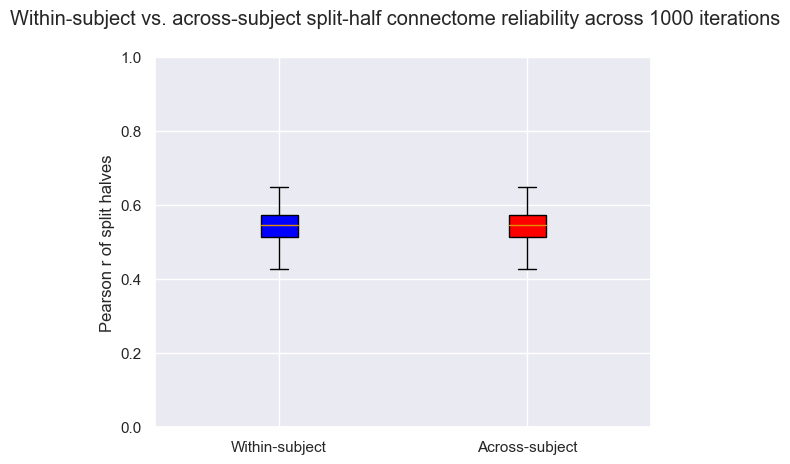

In [7]:
# plot the results
fig, ax = plt.subplots(1,1)
fig.suptitle('Within-subject vs. across-subject split-half connectome reliability across 1000 iterations')
ax.boxplot(avg_within_sub_corr, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue'), labels=['Within-subject'])
ax.boxplot(avg_within_sub_corr, positions=[2], patch_artist=True, boxprops=dict(facecolor='red'), labels=['Across-subject'])
ax.set_ylabel('Pearson r of split halves')
ax.set_ylim(0,1)
plt.show()

### 4. Finally, average connectomes within subject and re-save (if they are reliable!)

In [8]:
for sub in data_dict.keys():
    connectome_avg = np.mean([data_dict[sub][ses]['connectome'] for ses in data_dict[sub].keys()], axis=0)
    np.save(f"outputs/connectomes/{sub}_connectome_avg.npy", connectome_avg)